## Replication of Keller et al. (2026) on the TRAPPIST-1 Case
A study on how higher-order resonances can form in just Type I migration.

#### Imports and Units

In [1]:
import numpy as np
import pandas as pd
import pickle
import scipy
import matplotlib.pyplot as plt
import trappist1_sim as t1
from time import time
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')

# Unit conversions
AU = u.AU.to(u.cm)    
Msun = u.Msun.to(u.g) 
yr = u.yr.to(u.s)    
r_earth = u.earthRad.to(u.AU)
m_earth = u.Mearth.to(u.Msun)
r_sun = u.Rsun.to(u.AU) 

/opt/homebrew/lib/python3.14/site-packages/reboundx/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


#### Choosing parameters and bounds
We are studying the TRAPPIST-1 system. Masses will be drawn from Gaussians based on data from Agol et al. (2021). Though the masses will vary, we are mostly interested in how the initial period ratios and the $K$-factor will affect the outcomes of the simulation.

In [2]:
N = 5
    
bounds = {
    "m1": (1e-6, 1e-4),
    "m2": (1e-6, 1e-4),
    "m3": (1e-6, 1e-4),
    "m4": (1e-6, 1e-4),
    "m5": (1e-6, 1e-4),
    "m6": (1e-6, 1e-4),
    "m7": (1e-6, 1e-4),
    "PR1": (1.2, 2.5),
    "PR2": (1.2, 2.5),
    "PR3": (1.2, 2.5),
    "PR4": (1.2, 2.5),
    "PR5": (1.2, 2.5),
    "PR6": (1.2, 2.5),
    "K_factor": (1, 100)
}

# param_sets = sample_parameters(N, bounds)

# results = []

# for i, params in enumerate(param_sets):
#     print(f"Running simulation {i+1}/{N}")
#     result = run_simulation(params, sim_id=i)
#     results.append(result)

# save_results(results)

#### Randomly generate mass, radius, & semimajor axis values
Planetary parameters taken from the NASA Exoplanet Archive, based on Agol 2021.

In [3]:
planet_names = ['b', 'c', 'd', 'e', 'f', 'g', 'h']

# Nested dict containing params for each planet in sim
planet_params = {f"{planet_name}": t1.generate_params(f'TRAPPIST-1_params/TRAPPIST-1_{planet_name}_planet_params.csv', ('a (au)', 'Rp (R⨁)', 'Mp (M⨁)')) for planet_name in planet_names}
stellar_params = t1.generate_params('TRAPPIST-1_params/TRAPPIST-1_stellar_params.csv', ('R✶ (R⦿)', 'M✶ (M⦿)'))

print(planet_params, stellar_params)

{'b': {'a (au)': array([0.01146443]), 'Rp (R⨁)': array([1.10859627]), 'Mp (M⨁)': array([1.41496229])}, 'c': {'a (au)': array([0.01588175]), 'Rp (R⨁)': array([1.09316273]), 'Mp (M⨁)': array([1.30280963])}, 'd': {'a (au)': array([0.02212111]), 'Rp (R⨁)': array([0.78245446]), 'Mp (M⨁)': array([0.39369631])}, 'e': {'a (au)': array([0.03265611]), 'Rp (R⨁)': array([0.91899752]), 'Mp (M⨁)': array([0.69209305])}, 'f': {'a (au)': array([0.03781375]), 'Rp (R⨁)': array([1.04781044]), 'Mp (M⨁)': array([1.0197308])}, 'g': {'a (au)': array([0.04718391]), 'Rp (R⨁)': array([1.12542493]), 'Mp (M⨁)': array([1.35906062])}, 'h': {'a (au)': array([0.06162819]), 'Rp (R⨁)': array([0.74567367]), 'Mp (M⨁)': array([0.35220618])}} {'R✶ (R⦿)': array([0.1201801]), 'M✶ (M⦿)': array([0.08828078])}


#### Sim Params
Based on section 2.1 in Keller et al. (2026).

In [4]:
# Define planet masses (m)
m_vals = np.array([planet_params[planet_name]['Mp (M⨁)'] for planet_name in planet_names])
m_vals *= m_earth # convert to Msun

# Define planet radii (r)
r_vals = np.array([planet_params[planet_name]['Rp (R⨁)'] for planet_name in planet_names])
r_vals *= r_earth # convert to AU

# Define stellar parameters
m_star = stellar_params['M✶ (M⦿)']
r_star = stellar_params['R✶ (R⦿)'] * r_sun

# Draw initial ratios from log normal
initial_P_ratios = np.random.lognormal(0.45, 0.1, size=len(planet_names)-1) 
                                     # In Keller, 0.703 & 0.313
                                     
# Draw surface density at 1au from log uniform
Sigma_1au = scipy.stats.loguniform.rvs(a=10, b=1000, size=1) # in g/cm^2
                            # In Keller, 10 & 10000
Sigma_1au *= AU**2 / Msun # unit conversion for sim
print(f"Sigma_1au: {float(Sigma_1au):.3e}")

# Draw K-factor from log uniform and solve for h
K_factor = scipy.stats.loguniform.rvs(a=100, b=300, size=1)
                            # In Keller, 10 & 1000

Sigma_1au: 4.972e-05


In [5]:
t1.simulate_trappist1(m_vals, r_vals, m_star, r_star, initial_P_ratios, Sigma_1au, K_factor, planet_names)
saved_sim = t1.load_simulation_run(sim_id=0, filename="simulation_data.h5")
sim_data = saved_sim[0]
b = sim_data['b']
c = sim_data['c']
d = sim_data['d']
e = sim_data['e']
f = sim_data['f']
g = sim_data['g']
h = sim_data['h']

# Example usage
# print(saved_sim[1]['m_star'])
# print(b_data[:5])
# print(b_data['a'][:5])
# print(b_data.attrs["planet_name"])

Initial period ratios:
[1.552  1.6179 1.5061 1.6536 1.3173 1.7141]

Initial period values (yr):
[0.0376 0.0584 0.0945 0.1423 0.2353 0.31   0.5314]
h_1au: 0.02565
tau_a of b: 1.149e+08
Integrated to 0.1 kyrs in 0.7422 sec


#### Plot it!

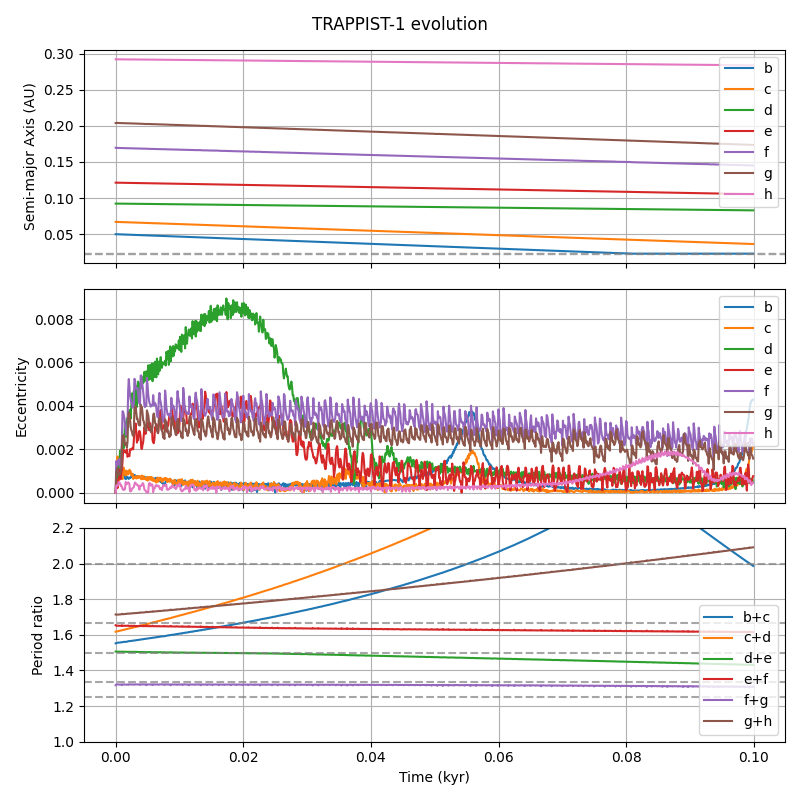

In [6]:
%matplotlib widget
t1.plot_trappist1(saved_sim)

#### Identifying MMRs
Based on section 2.3 in Keller et al. (2026).

**Note:** Alternatively, we can use $\zeta$ given in Eq. 11 in Fabrycky et al. (2014) to determine the period ratio. As of now this $\zeta$ is for first-order MMRs only.

In [7]:
def find_best_twoBR_pq(b, c, p_max=10, crit="Delta"):
    '''Finds the best values for p and q at the end of simulation for 
       two planets given some MMR criterion'''
    if crit == 'Delta':
        best_Delta = 100
    elif crit == 'zeta':
        best_zeta = 100
        
    best_p, best_q = 100, 100
    
    for p in range(1, p_max+1):
        for q in range(1, p):
            # Use Kepler's law to find period values
            P_b = (b['a'].iloc[-1]**3 / m_star)**(1/2)
            P_c = (c['a'].iloc[-1]**3 / m_star)**(1/2)
            
            if crit == 'Delta':
                Delta = (P_c/P_b)/(p/q) - 1
                if np.abs(Delta) < np.abs(best_Delta):
                    best_Delta = Delta
                    best_p, best_q = p, q
            elif crit == 'zeta':
                zeta = 3*(1/(P_b/P_c-1) - round(1/(P_b/P_c-1)))
                if np.abs(zeta) < np.abs(best_zeta):
                    best_zeta = zeta
                    best_p, best_q = p, q
                    
    return best_p, best_q

def find_best_threeBR_pq(b, c, d, p_max=10, crit="Delta"):
    best_p_bc, best_q_bc = find_best_twoBR_pq(b, c, p_max, crit)
    best_p_cd, best_q_cd = find_best_twoBR_pq(c, d, p_max, crit)          
    return best_p_bc, best_q_bc, best_p_cd, best_q_cd

with open("fg_library.pkl", "rb") as f:
    fg_lib = pickle.load(f)
    
def twoBR_angle(b, c, p, q):
    f, g = fg_lib[(p, q)]
    pomega_hat = np.arctan2((f*b['e']*np.sin(b['pomega']) + g*c['e']*np.sin(c['pomega'])), (f*b['e']*np.cos(b['pomega']) + g*c['e']*np.cos(c['pomega'])))
    return q*b['l'] - p*c['l'] + (p-q)*pomega_hat

def threeBR_angle(b, c, d, p_bc, q_bc, p_cd, q_cd):
    return (p_cd-q_cd)*(q_bc*b['l'] - p_bc*c['l']) + (p_bc-q_bc)*(-q_cd*c['l'] + p_cd*d['l'])

def libration_amp(angles, N):
    '''Calculates libration amplitude of angles using last N samples'''
    mean_angle = np.average(angles)
    return np.sqrt(2/N * np.sum((angles-mean_angle)**2))

True period ratio: 1.9867
p, q: 2, 1


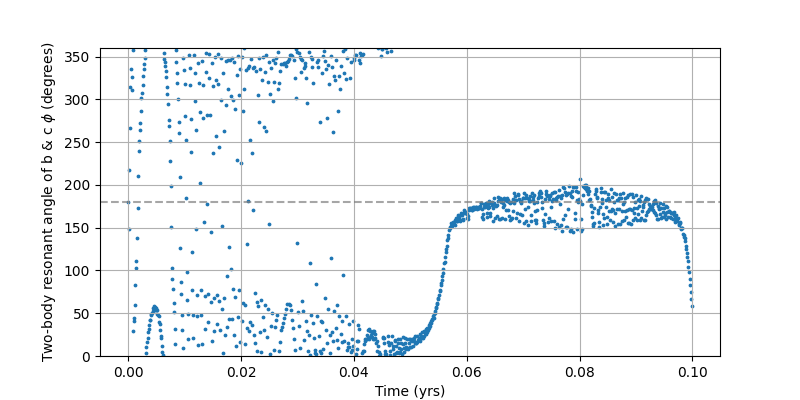

In [9]:
def last_P(b):
    '''Returns the period value given name of planet'''
    return float(b['a'].iloc[-1]**3 / m_star)**(1/2)

def plot_libration(b, c, d=None, t_units='kyr'):
    b_name = b.attrs["planet_name"]
    c_name = c.attrs["planet_name"]
    times = b['time']
    
    # 2BR angle
    if d is None:
        print(f"True period ratio: {last_P(c) / last_P(b):.4f}")

        # Calculate two-body resonant angle between b and c
        p, q = find_best_twoBR_pq(b, c)

        assert p != 100 # if not, then the planets are definitely not in resonance
        print(f"p, q: {p}, {q}")
        twoBR = np.rad2deg(twoBR_angle(b, c, p, q))

        plt.figure(figsize=(8,4))
        
        if t_units == 'kyr':
            plt.scatter(times/1000, twoBR%360, s=3) # mod 360 so it wraps
        plt.axhline(180, color='gray', ls='--', alpha=0.7)
        plt.xlabel("Time (yrs)")
        plt.ylabel(f"Two-body resonant angle of {b_name} & {c_name} $\phi$ (degrees)")
        plt.ylim(0,360)
        plt.grid(True)
        plt.show()
    
    # 3BR angle
    else:
        d_name = d.attrs["planet_name"]
        print(f"True period ratios: b+c: {last_P(c) / last_P(b):.4f}, c+d: {last_P(d) / last_P(c):.4f}")
        
        # Calculate three-body resonant angle between b, c, and d
        p_bc, q_bc, p_cd, q_cd = find_best_threeBR_pq(b, c, d)
        
        assert p_bc != 100; assert p_cd != 100 # if not, then the planets are definitely not in resonance
        print(f"p_{b_name}{c_name}, q_{b_name}{c_name}, p_{c_name}{d_name}, q_{c_name}{d_name}: {p_bc}, {q_bc}, {p_cd}, {q_cd}")
        threeBR = np.rad2deg(threeBR_angle(b, c, d, p_bc, q_bc, p_cd, q_cd))

        plt.figure(figsize=(8,4))
        
        if t_units == 'kyr':
            plt.scatter(times/1000, threeBR%360, s=3) # mod 360 so it wraps
        plt.axhline(180, color='gray', ls='--', alpha=0.7)
        plt.xlabel("Time (yrs)")
        plt.ylabel(f"Three-body resonant angle of {b_name}, {c_name}, & {d_name} $\phi$ (degrees)")
        plt.ylim(0,360)
        plt.grid(True)
        plt.show()
    
plot_libration(b, c)
# plot_libration(b, c, e)
